# Land Use Categorization for TMD23
This is intended to be a demo implementing the new definitions of land use categorizations for the Trip Generation step of the TDM23 (travel demand model in development). This notebook starts with categorization of Central Business Districts (CBDs).


Started March 30th, 2021 - Margaret Atkinson

#### Requirements:
This is running as a ipynb in Jupyter Notebooks in an Anaconda environment that contains the following:
- Python 3.7
- numpy
- pandas
- openmatrix
- matplotlib
- descartes
- ipympl
- geopandas
- nb_conda
- nb_conda_kernels
- folium
- branca
- jenkspy (INSTALL FIRST)

For more information on how this environment was set up, see: https://github.com/bkrepp-ctps/mde-prototype-python

#### Just a note about environments:

This script seems to require pyproj > 2.2. The environment base_py_37_branca seems to have this.

Hypothesis: In order for pyproj to deal with CRS (coordinate reference systems) in the geodataframes - we need to be using the most recent version of pyproj. See: https://geopandas.org/docs/user_guide/projections.html#upgrading-to-geopandas-0-7-with-pyproj-2-2-and-proj-6

This changes how we specify CRSs. Also note that going from pivot table back to geodataframe (even though the pivot table has geometry) we need to specify the CRS - which should be the same CRS that the data came out of.

Using a version of pyproj that uses the {'init': 'ESPG4326'} format is giving me inconsistent results - sometimes maintaining the CRS and sometimes not. This causes the buffers to be larger than desired and causes problems for spatial join.


#### Links about Decay Functions
- https://aceso.readthedocs.io/_/downloads/en/latest/pdf/
- https://geographicdata.science/book/notebooks/04_spatial_weights.html
- https://github.com/pysal/pysal


## Definitions:
Higher classes are exclusions for lower classes (e.g. if TAZ is both CBD and Dense Urban, it will only be CBD).
### CBD
CBD: A TAZ is marked as a CBD if it is within 0.5 miles of two heavy rail (subway) stops from two different lines or a green line stop that serves all four branches.

Methodology Plan: Buffer each heavy rail stop and dissolve by line to get one buffer per heavy rail line and one buffer for the green line (light rail) for the four stops that serve all four branches of the green line.. 
 - Method 2: Intersect heavy rail buffers (and 4 light rail buffers) to get polygons where buffers overlap each other. Dissolve those polygons into one polygon. If dissolved buffer polygon covers over 50% of the TAZ, it is a CBD.
 - Method 1: Count the number of heavy rail line buffers intersect with each TAZ. If number is >1, the TAZ is a CBD. (NOT USED)

Data: (shapefiles)
- TAZ's (polygons)
- Heavy Rail Stops with Line field (points)

Notes:
- May also have an additional filter: 
    - The TAZ must be over 50% covered by the overlap of two heavy rail stop buffers of different lines (like red/orange)

### Dense Urban
#### Basic Definition:

OLD:
(0.5 mile buffer for heavy rail stops) OR (0.5 mile buffer for CR stops AND Urban density of landuse) OR (0.5 mile buffer for 5 mins headway overlapping bus routes AND Urban density of model landuse)

- *headway is frequency - buses must run every 5 minutes in the AM model period*
- we will be using the combined headway procedure from the model for nodes where the headway 5 min or less means that there are 36 buses or more per 3 hours (AM time period). These nodes will be buffered to meet the criteria for overlapping bus routes (but the buffers need not overlap).

NEW: 
(0.5 mile buffer for heavy rail stops) OR (0.5 mile buffer for CR stops AND Urban density of landuse) OR (0.5 mile buffer for all nodes that have a frequency >= 36 during the AM Peak Period AND Urban density of model landuse)

#### GIS Definition:

A TAZ is defined as Dense Urban if the TAZ does not meet the criteria for a CBD and meets one of the follow criteria:
1. TAZ must intersect with a 0.5 mile buffer for heavy rail stops OR 
2. (a TAZ must intersect with a 0.5 mile buffer for CR stops AND meet the landuse density threshold for Urban density) OR 
3. (a TAZ must intersect with a 0.5 mile buffer for a node that has a frequency >= 36 during the AM Peak Period in the model AND the TAZ must meet the landuse density threshold for Urban density)

#### Density (calculated at the TAZ level):

Density = (Population + Employment)/Area in Sq Mi
- [1] Urban density range is 10,000 - 3,805,119 ;  
- [2] Suburban density range is 5,000 - 9,999 ;  
- [3] Rural density is 0 - 4,999 ; 
- Boston Core includes TAZs 1-155 (we don't need this usually urban density, will fall in Urban density)

#### Notes: 
- Excludes CBD
- No overlapping heavy rail stops
- the 5 min node frequency file is MBTA only, the 15 min node frequency file is all bus routes in the state (private buses, RTAs, etc.).

#### Data:
- Heavy rail stops (points) = Blue, Orange, Red lines (including Mattapan which counts as Red)
- Commute Rail stops (points)
- TAZs with population and employment (polygons)
- Bus routes with AM headway (5 minutes) 
    - (lines) = Modes 1, 2, 3, use AM_Headway <= 5
    - only MBTA


### Fringe Urban
(1  mile buffer for heavy rail stops) OR (0.5 mile buffer for light rail stops) OR (0.5 mile buffer for all nodes that have a frequency >= 36 during the AM Peak Period in the model AND Suburban density) OR (0.5 mile buffer for CR stops AND Suburban density of model  landuse)

***Green line and Silver line are light rail (multiple modes, use them all) 


#### GIS Definition:

A TAZ is defined as Fringe Urban if the TAZ does not meet the criteria for a CBD or Dense Urban and meets one of the follow criteria:
1. TAZ must intersect with a 1 mile buffer for heavy rail stops OR 
2. (TAZ must intersect with a 0.5 mile buffer for light rail stops) OR
3. (a TAZ must intersect with a TAZ must intersect with a 0.5 mile buffer for a node that has frequency >= 12 during the AM Peak Period in the model AND the TAZ must meet the landuse density threshold for suburban density) OR
4. (a TAZ must intersect with 0.5 mile buffer for CR stops AND meet the landuse density threshold for suburban density)

#### Data:
- Heavy rail stops (points) = Blue, Orange, Red lines (including Mattapan which counts as Red)
- Commuter Rail stops (points)
- Light Rail stops (points) = Green and Silver lines.
- TAZs with population and employment (polygons)
- Bus routes with AM headway (15 minutes) 
    - NOT only MBTA

### Suburban
Basic Definition:
0.5 mile buffer for any transit line (exclude CR , private buses)

GIS Definition:
TAZs that are not CBD, Dense Urban, or Fringe Urban AND intersect with a 0.5 mile buffer for any transit line (excluding CR and private bus lines).

### Rural
Definition of exclusion:
All TAZs that are not CBD, Dense Urban, Fringe Urban, or Suburban.

In [37]:
#IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import copy

In [87]:
#Import Data
#import TAZ shapefile
#(https://geopandas.org/docs/user_guide/io.html)
#taz = "G:\Data_Resources\DataStore\Ben_Marg_Proto\candidate_CTPS_TAZ_STATE_2019.shp"
taz = "G:\Regional_Modeling\Projects\Landuse Type_Project\To Margrate\TAZ_LUType_CRS.shp"
    #load into a geodataframe
taz = gpd.read_file(taz)
    #filter to just be TAZ ID and geometry
taz = taz[['ID',"TOT_EMP", "TOT_POP",'geometry', 'AREA']]
    #rename ID to TAZ_ID
taz = taz.rename(columns={"ID":"TAZ_ID"})

#import all transit routes
routes = r"G:\Regional_Modeling\Projects\Landuse Type_Project\To Margrate\LRTP Routes_05.11.2021\Model_Routes_CRS.shp"
routes = gpd.read_file(routes)
routes = routes.query('SCEN_00 == 1') #filter to include just in current scenario

#import all stops (must have line column)
stops = r"G:\Regional_Modeling\Projects\Landuse Type_Project\To Margrate\LRTP Routes_05.11.2021\Model_Stops_CRS.shp"
stops = gpd.read_file(stops)
stops = stops[stops['ROUTE_ID'].isin(routes['ROUTE_ID'])] #filter to include just in current scenario (e.g. in routes)

#transform TAZ and stop layers' CRS to CTPS Standard - "EPSG:26986" (Massachusetts State Plane)
taz = taz.to_crs("EPSG:26986")
stops = stops.to_crs("EPSG:26986")
#stops2 = stops2.to_crs("EPSG:26986")
routes = routes.to_crs("EPSG:26986")

#import 5min headway and 15min headway
f5 = r'G:\Regional_Modeling\Projects\Landuse Type_Project\Node GISDK work\results\Aggr_Stops_5minheadway.csv'
f15 = r"G:\Regional_Modeling\Projects\Landuse Type_Project\Node GISDK work\results\Aggr_Stops_15minheadway.csv"
f5 = pd.read_csv(f5, header = 0, names = ['NODE', 'FREQ5']) #data does not come with header for either csv
f15 = pd.read_csv(f15, header = 0, names = ['NODE', 'FREQ15'])

stops.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Filtering and Cleaning the Data
This section is about filtering and setting up data products for use in all future sections. This means that the analysis for each section doesn't involve setting up data and data that is shared is stored in a common place.

In [88]:
stops.columns

Index(['ID', 'ROUTE_ID', 'MODE', 'STOP_NAME', 'NODE', 'DIR_CODE', 'DIR',
       'ROUTE_NAME', 'SCEN_00', 'geometry'],
      dtype='object')

In [89]:
#FILTER THE STOPS

#HEAVY RAIL (CBD, DENSE URBAN, FRINGE URBAN)
#filter all stops to just heavy rail stops (and make a copy)
hr_stops = copy.deepcopy(stops.loc[stops['MODE'].isin([5,6,7,8])]) 
#mode 4 is Green, 5 is Red, Mattapan is 6 (Ashmont to Mattapan), Blue is 8, Orange is 7
    #Treat Mattapan as 5 (red)
    #https://stackoverflow.com/questions/34499584/use-of-loc-to-update-a-dataframe-python-pandas
#hr_stops['MODE'] = hr_stops['MODE'].replace(6,5) #don't use this line - gives SettingWithCopyWarning
hr_stops.loc[hr_stops['MODE'] == 6, 'MODE'] = 5 #this line does the same thing as above
#filter
hr_stops = hr_stops.loc[:,['ID', 'MODE', 'STOP_NAME', 'geometry']]
#check
hr_stops[hr_stops['MODE'].isin([6])] 
#hr_stops[hr_stops['MODE'].isin([5])]['STOP_NAME'].tolist()

,ID,MODE,STOP_NAME,geometry


In [90]:
#COMMUTER RAIL (DENSE URBAN, FRINGE URBAN)
#filter all stops to just commuter rail stops (and make a copy)
cr_stops = copy.deepcopy(stops.loc[stops['MODE'].isin([9,32,33,34,35,36,37,38,39,40])]) 
#filter
cr_stops = cr_stops.loc[:,['ID', 'MODE', 'STOP_NAME', 'geometry']]
cr_stops.head()

,ID,MODE,STOP_NAME,geometry
20946,247157,32,NORTH STATION_ROCKPORT,POINT (236066.773 901844.302)
20947,247158,32,RIVER WORKS,POINT (243637.455 911189.761)
20948,247159,32,SALEM,POINT (249644.649 919538.922)
20949,247160,32,CHELSEA,POINT (238323.440 905121.969)
20950,247161,32,SWAMPSCOTT,POINT (247487.350 913848.626)


In [91]:
#LIGHT RAIL (FRINGE URBAN & CBD)
#filter all stops to just light rail stops (and make a copy)
lr_stops = copy.deepcopy(stops.loc[stops['MODE'].isin([4,12,13])]) 
#filter
lr_stops = lr_stops.loc[:,['ID', 'MODE', 'STOP_NAME', 'geometry']]
all4_lrStop = copy.deepcopy(lr_stops.loc[lr_stops['STOP_NAME'].isin(['PARK STREET GREEN', 'BOYLSTON','ARLINGTON','COPLEY SQUARE'])])#, 'HYNES / ICA', 'KENMORE'])]) 
all4_lrStop = all4_lrStop.loc[:,['ID', 'MODE', 'STOP_NAME', 'geometry']]
all4_lrStop

,ID,MODE,STOP_NAME,geometry
19817,258495,4,COPLEY SQUARE,POINT (234848.775 900041.800)
19827,258485,4,ARLINGTON,POINT (235369.155 900241.674)
19828,258484,4,BOYLSTON,POINT (235826.392 900361.400)
19829,258483,4,PARK STREET GREEN,POINT (236050.578 900762.205)
19837,258515,4,COPLEY SQUARE,POINT (234848.611 900041.688)
19847,258505,4,ARLINGTON,POINT (235369.155 900241.674)
19848,258504,4,BOYLSTON,POINT (235826.392 900361.400)
19849,258503,4,PARK STREET GREEN,POINT (236050.578 900762.205)
19863,211943,4,COPLEY SQUARE,POINT (234848.611 900041.688)
19864,211942,4,ARLINGTON,POINT (235369.072 900241.674)


In [92]:
#Just get Nodes from Stops (DENSE URBAN, FRINGE URBAN)
nodes = copy.deepcopy(stops.groupby('NODE').first().reset_index()) #this makes it one record per node id
nodes = nodes[['NODE', 'geometry']]
    #merge with the frequency data
nodes = nodes.merge(f5, how = 'left', on = 'NODE')
nodes = nodes.merge(f15, how = 'left', on = 'NODE')
nodes = nodes.dropna(how = 'any', thresh=3) #make sure if both are null not using.
nodesf5 = nodes.query('FREQ5 >= 36') #this filters so headway < 5min and only bus modes 1,2,3 (because thats whats in the file)
nodesf15 = nodes.query('FREQ15 >= 12') #this filters so headway < 15min
nodesf15

,NODE,geometry,FREQ5,FREQ15
287,10047,POINT (212585.258 855045.554),NaN,18.000000
292,10112,POINT (214568.492 858438.988),NaN,12.000000
293,10113,POINT (214766.133 858332.660),NaN,12.000000
304,10237,POINT (211731.476 852172.721),NaN,15.000000
308,10248,POINT (211920.784 852757.817),NaN,12.000000
...,...,...,...,...
9766,231007,POINT (109478.946 873467.359),NaN,166.000000
9770,231067,POINT (234287.809 897750.843),499.993562,499.993562
9772,231094,POINT (232429.953 894520.798),87.988510,87.988510
9773,231109,POINT (234823.650 902384.535),146.999998,146.999998


In [93]:
#ROUTES FOR SUBURBAN
sub_routes = copy.deepcopy(routes.loc[routes['MODE'].isin([1,2,3,4,5,6,7,8,12,13,17,18,19,20,21,22,41,42,43])]) 
sub_routes

,ROUTE_ID,ROUTE_NAME,DIR_CODE,DIR,MODE,SCEN_00,SCEN_00_AM,geometry
0,315,354:Boston via Medford Square &,IB,IB or SB,3,1,0.00,"LINESTRING (225301.470 915006.825, 225304.260 ..."
1,316,354:Boston via West Cummings & I,IB,IB or SB,3,1,0.00,"LINESTRING (225301.470 915006.825, 225304.260 ..."
2,317,354:Boston via Woburn Square & I,IB,IB or SB,3,1,23.68,"LINESTRING (225301.470 915006.825, 225304.260 ..."
3,436,450.9:West Lynn Garage,IB,IB or SB,2,1,0.00,"LINESTRING (249331.464 919417.184, 249312.961 ..."
4,1162,351.3:Oak Park & Bedford Woods,OB,OB or NB,2,1,45.00,"LINESTRING (229418.568 905333.834, 229416.508 ..."
...,...,...,...,...,...,...,...,...
1397,8493,28:Mattapan,OB,OB or NB,1,1,3.91,"LINESTRING (233821.108 898461.032, 233833.720 ..."
1398,8494,28.6:Mattapan,OB,OB or NB,1,1,0.00,"LINESTRING (233551.536 897943.675, 233617.222 ..."
1399,8495,45:Franklin Park,OB,OB or NB,1,1,12.00,"LINESTRING (233821.108 898461.032, 233833.720 ..."
1400,8496,45.1:Ashmont,OB,OB or NB,1,1,0.00,"LINESTRING (233821.108 898461.032, 233833.720 ..."


In [94]:
#Calculate Density for TAZs
#Density = (Population + Employment)/Area in Sq Mi
    #TAZs units are in meters (CRS) so convert to miles
######TESTING#########
#taz = "G:\Regional_Modeling\Projects\Landuse Type_Project\To Margrate\TAZ_LUType_CRS.shp"
    #load into a geodataframe
#taz = gpd.read_file(taz)

    #filter to just be TAZ ID and geometry
#taz = taz[['ID',"TOT_EMP", "TOT_POP",'geometry', 'AREA', 'DENSITY']]
    #rename ID to TAZ_ID
#taz = taz.rename(columns={"id":"TAZ_ID"})
#taz['AreaPy'] = taz['geometry'].area *0.00000038610215855
#######END TESTING#####

taz['DensPy'] = (taz['TOT_POP']+taz['TOT_EMP'])/taz['AREA']

#Flag Urban, Suburban, Rural
taz['Den_Flag'] = np.where(taz['DensPy'] >= 10000, 1, 
                          np.where(taz['DensPy'] < 5000, 3, 2))
taz.loc[taz['Den_Flag']<3]

,TAZ_ID,TOT_EMP,TOT_POP,geometry,AREA,DensPy,Den_Flag
78,1891,2970.0,348.0,"POLYGON ((249498.429 878242.384, 249438.536 87...",0.641429,5172.825052,2
89,1834,4075.0,685.0,"POLYGON ((247949.885 882747.003, 247946.553 88...",0.769503,6185.810842,2
90,1832,292.0,3460.0,"POLYGON ((248009.987 883320.896, 247949.885 88...",0.681402,5506.294375,2
92,1902,1746.0,133.0,"POLYGON ((251156.619 879694.204, 251173.163 87...",0.285792,6574.711678,2
96,1858,1224.0,446.0,"POLYGON ((251263.535 888455.789, 251254.866 88...",0.319264,5230.780796,2
...,...,...,...,...,...,...,...
4478,1931,1851.0,222.0,"POLYGON ((268345.197 929108.016, 268359.054 92...",0.117916,17580.311408,1
4481,1936,1109.0,2645.0,"POLYGON ((273757.694 934760.066, 273746.269 93...",0.569050,6596.959845,2
4486,1928,402.0,1123.0,"POLYGON ((268130.277 929943.313, 268133.322 92...",0.078450,19439.133206,1
4487,1930,866.0,3148.0,"POLYGON ((269009.004 929886.603, 269000.039 92...",0.361573,11101.492645,1


## CBD

<AxesSubplot:>

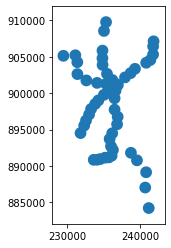

In [95]:
#BUFFER CELL

#convert the 0.5 mile buffer distance into meters (CRS is in meters)
buf5 = 0.5*1609.34

#make a copy of hr_stops to buffer
hr_buf = copy.deepcopy(hr_stops) #new used to just be hr_buf = hr_stops

#Buffer the heavy rail stops
#(https://geopandas.org/docs/user_guide/geometric_manipulations.html)
#(https://gis.stackexchange.com/questions/253224/geopandas-buffer-using-geodataframe-while-maintaining-the-dataframe)
    #keep attribute data by replacing the geometry column
hr_buf['geometry']= hr_buf.buffer(buf5)

#group by line and dissolve
#(https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html)
    #.reset_index() is because the by=field will turn the field into the index and have it not be a col
hr_buf_dis = hr_buf.dissolve(by='MODE').reset_index()

#only get what we need
hr_buf_dis = hr_buf_dis[['MODE', 'geometry']]
hr_buf_dis.plot()

In [96]:
#BUFFER CELL

#convert the 0.25 mile buffer distance into meters (CRS is in meters)
buf5 = 0.25*1609.34

#make a copy of hr_stops to buffer
lr4_buf = copy.deepcopy(all4_lrStop) #new used to just be hr_buf = hr_stops

#Buffer the light rail stops
#(https://geopandas.org/docs/user_guide/geometric_manipulations.html)
#(https://gis.stackexchange.com/questions/253224/geopandas-buffer-using-geodataframe-while-maintaining-the-dataframe)
    #keep attribute data by replacing the geometry column
lr4_buf['geometry']= lr4_buf.buffer(buf5)

#group and dissolve
#(https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html)
    #.reset_index() is because the by=field will turn the field into the index and have it not be a col
lr4_buf_dis = lr4_buf.dissolve(by='MODE').reset_index()

#only get what we need
lr4_buf_dis = lr4_buf_dis[['MODE', 'geometry']].reset_index()
lr4_buf_dis

,index,MODE,geometry
0,0,4,"POLYGON ((234848.199 899639.240, 234808.764 89..."


In [97]:
#make sure everything is kosher
#hr_buf_dis.crs="EPSG:26986"
#hr_buf_dis = gpd.GeoDataFrame(hr_buf_dis)

#hr_buf_dis.plot()
#hr_buf_dis.crs="EPSG:26986"
lr4_buf_dis.crs 

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### CBD: Intersect and Count Method TWO!

<AxesSubplot:>

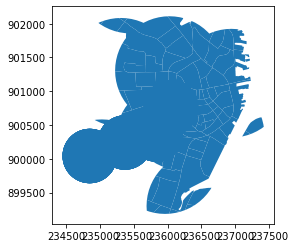

In [98]:
#INTERSECT TRY 2
#split into individual geodataframes to intersect
red = hr_buf_dis[hr_buf_dis['MODE'] == 5]
blue = hr_buf_dis[hr_buf_dis['MODE'] == 7]
orange = hr_buf_dis[hr_buf_dis['MODE'] == 8]

#get all overlaps between route buffers
rb = gpd.overlay(red, blue, how='intersection')
ob = gpd.overlay(orange, blue, how='intersection')
ro = gpd.overlay(red, orange, how= 'intersection')

#put overlaps into one file with overlaps not overlapping (union)
rbob = gpd.overlay(rb, ob, how='union')
rbobro = gpd.overlay(rbob, ro, how='union',keep_geom_type=False)
#turn ino one row multi part polygon
rbobro['MODE'] = 578
rbobro = rbobro.dissolve(by='MODE').reset_index()
#add in the light rail
rbobro = rbobro.append(lr4_buf)
#rbobro['MODE'] = '578+g4'
#rbobro = rbobro.dissolve(by='MODE').reset_index()
#get only fields we need
rbobro = rbobro[['MODE', 'geometry']]
rbobro

taz_hr = gpd.overlay(taz, rbobro, how='intersection')
taz_hr
taz_hr.plot()

,TAZ_ID,TOT_EMP,TOT_POP,geometry,DensPy,Den_Flag,CBD_Flag
3819,60,2242.0,0.0,"POLYGON ((236565.617 900442.592, 236559.535 90...",566877.370417,1,1
3435,91,1014.0,406.0,"POLYGON ((235142.766 900260.496, 234965.958 90...",82438.316401,1,1
3411,79,986.0,237.0,"POLYGON ((235708.409 899897.901, 235710.048 89...",103503.723764,1,1
3424,19,3935.0,0.0,"POLYGON ((236620.143 899734.087, 236538.633 89...",87893.678803,1,1
2981,28,924.0,2417.0,"POLYGON ((235472.151 900720.237, 235470.732 90...",75751.048634,1,1


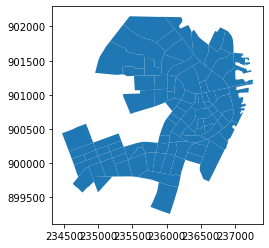

In [111]:
#COUNT TRY 2
#caculate area
#taz_hr.area
taz_hr['area_int'] = taz_hr.area
taz['taz_area'] = taz.area
#join intersecting areas back to main TAZ
taz_int = taz.merge(taz_hr, how='left', on='TAZ_ID')
#get percent of taz that is intersecting
taz_int['perc_hr'] = taz_int['area_int']/taz_int['taz_area']

#flag TAZ's
#flag as cbd if taz is over half covered by buffer, density is urban 
taz_int['CBD_Flag'] = np.where(((taz_int.perc_hr >0.5)&(taz_int.Den_Flag_x ==1)), 1, 0)
#don't do density filter on heavy rail overlaps, just for light rail
#taz_int['CBD_Flag'] = np.where((taz_int.perc_hr >0.5) | ((taz_int.Den_Flag_x ==1)&(taz_int.perc_hr >0.5)&(taz_int.MODE ==4)), 1, 0)

#turn back into geodataframe - geometry is TAZ (not intersections of TAZ and buffers)
taz_int = taz_int.rename(columns={'geometry_x':'geometry', 'TOT_EMP_x' : 'TOT_EMP', 'TOT_POP_x': 'TOT_POP',
                                  'DensPy_x':'DensPy', 'Den_Flag_x': 'Den_Flag'})
taz_int = gpd.GeoDataFrame(taz_int)
taz_int = taz_int[['TAZ_ID', 'TOT_EMP', 'TOT_POP', 'geometry', 'DensPy', 'Den_Flag', 'CBD_Flag']]#, 'CBD_Perc']]

#make sure that taz_int doesn't have duplicates because of light rail and heavy rail being dif buf polygons
#first sort so that when deleting duplicates, deleting the ones that didn't pass CBD muster
taz_int = taz_int.sort_values(by = ['CBD_Flag'], ascending = False)
#delete duplicates
taz_int = taz_int.drop_duplicates('TAZ_ID')

#make testing outputs
CBD_TAZ2 = taz_int[taz_int['CBD_Flag'] == 1]
#CBD_TAZperc = taz_int[taz_int['CBD_Perc'] == 1]

CBD_TAZ2 = CBD_TAZ2[['TAZ_ID', 'geometry', 'CBD_Flag']]
#CBD_TAZperc = CBD_TAZperc[['TAZ_ID', 'geometry', 'CBD_Perc']]
CBD_TAZ2.plot()
#CBD_TAZperc.plot()
taz_int.head()

## Dense Urban 

In [112]:
#Buffering everything for Dense Urban
#convert the 0.5 mile buffer distance into meters (CRS is in meters)
buf5 = 0.5*1609.34

#make copies of everything to buffer
cr_buf = copy.deepcopy(cr_stops) #new used to just be hr_buf = hr_stops
hr_buf = copy.deepcopy(hr_stops) #replaces previous hr_buf, but idential to previous hr_buf
nodesf5_buf = copy.deepcopy(nodesf5)

#Buffer everything!!!
cr_buf['geometry']= cr_buf.buffer(buf5)
hr_buf['geometry']= hr_buf.buffer(buf5)
nodesf5_buf['geometry'] = nodesf5_buf.buffer(buf5)

#dissolve hr and cr and bus stops with headway < 5 min
hr_buf_dis_du = hr_buf.dissolve().reset_index()
cr_buf_dis = cr_buf.dissolve().reset_index()
nodesf5_buf_dis = nodesf5_buf.dissolve().reset_index()


In [113]:
#Calculate Flag Field
taz_du = copy.deepcopy(taz_int) #join basic taz with taz_int

#(already did bus above)
cr_list = []
hr_list = []
f5_list = []
count = 0

for index, row in gpd.overlay(hr_buf_dis_du, taz_du, how = 'intersection').iterrows():
    hr_list.append(row['TAZ_ID'])
for index, row in gpd.overlay(cr_buf_dis, taz_du, how = 'intersection').iterrows():
    cr_list.append(row['TAZ_ID'])
for index, row in gpd.overlay(nodesf5_buf_dis, taz_du, how = 'intersection').iterrows():
    f5_list.append(row['TAZ_ID'])

#taz_du['DU_Flag'] = np.where(((taz_du['CBD_Flag'] != 1) & (taz_du['TAZ_ID'].isin(hr_list))) | ((taz_du['CBD_Flag'] != 1) & (taz_du['TAZ_ID'].isin(cr_list)) & (taz_du['Den_Flag'] == 1)) | ((taz_du['CBD_Flag'] != 1) & (taz_du['TAZ_ID'].isin(f5_list)) & (taz_du['Den_Flag'] == 1)), 1,0)
taz_du['DU_Flag'] = np.where(((taz_du['TAZ_ID'].isin(hr_list))) | ((taz_du['TAZ_ID'].isin(cr_list)) & (taz_du['Den_Flag'] == 1)) | ((taz_du['TAZ_ID'].isin(f5_list)) & (taz_du['Den_Flag'] == 1)), 1,0)
taz_du.query('DU_Flag == 1') #862 records without CBD, 941 with CBD

,TAZ_ID,TOT_EMP,TOT_POP,geometry,DensPy,Den_Flag,CBD_Flag,DU_Flag
3819,60,2242.0,0.0,"POLYGON ((236565.617 900442.592, 236559.535 90...",566877.370417,1,1,1
3435,91,1014.0,406.0,"POLYGON ((235142.766 900260.496, 234965.958 90...",82438.316401,1,1,1
3411,79,986.0,237.0,"POLYGON ((235708.409 899897.901, 235710.048 89...",103503.723764,1,1,1
3424,19,3935.0,0.0,"POLYGON ((236620.143 899734.087, 236538.633 89...",87893.678803,1,1,1
2981,28,924.0,2417.0,"POLYGON ((235472.151 900720.237, 235470.732 90...",75751.048634,1,1,1
...,...,...,...,...,...,...,...,...
1604,529,238.0,2447.0,"POLYGON ((239246.076 909324.961, 239216.237 90...",10208.970206,1,0,1
1700,3381,80.0,1031.0,"POLYGON ((176195.484 925761.864, 176180.256 92...",17809.624571,1,0,1
1699,3382,986.0,914.0,"POLYGON ((176157.570 925524.163, 176079.329 92...",19594.497040,1,0,1
1701,3391,102.0,857.0,"POLYGON ((176695.121 925968.910, 176603.190 92...",11535.593139,1,0,1


<AxesSubplot:>

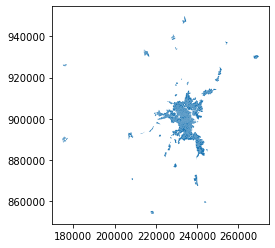

In [114]:
taz_du.query('DU_Flag == 1').plot()

## Fringe Urban

<AxesSubplot:>

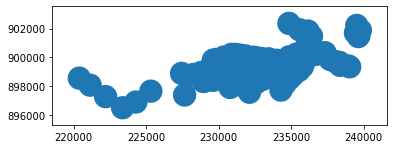

In [115]:
#Buffering everything for Fringe Urban
#convert the 0.5 and 1 mile buffer distances into meters (CRS is in meters)
buf5 = 0.5*1609.34
buf1 = 1*1609.34 #obvious but for clarity

#make copies of everything to buffer
cr_buf = copy.deepcopy(cr_stops) #new used to just be hr_buf = hr_stops
hr_buf1 = copy.deepcopy(hr_stops) #replaces previous hr_buf, but idential to previous hr_buf
nodesf15_buf = copy.deepcopy(nodesf15)
lr_buf = copy.deepcopy(lr_stops)

#Buffer everything!!!
cr_buf['geometry']= cr_buf.buffer(buf5)
hr_buf1['geometry']= hr_buf1.buffer(buf1) #buffer is now 1 mi
nodesf15_buf['geometry']= nodesf15_buf.buffer(buf5)
lr_buf['geometry']= lr_buf.buffer(buf5)

#dissolve hr and cr
hr_buf_dis_fu = hr_buf1.dissolve().reset_index()
cr_buf_dis = cr_buf.dissolve().reset_index()
nodesf15_buf_dis = nodesf15_buf.dissolve().reset_index()
lr_buf_dis = lr_buf.dissolve().reset_index()

lr_buf_dis.plot()

In [116]:
#Calculate Flag Field
taz_fu = copy.deepcopy(taz_du) #join basic taz with taz_int

cr_list = []
hr_list = [] #1 mile now
f15_list = []
lr_list = []

#For each row in the intersection output - take all the TAZs (will only be ones that intersect) and put in a list
for index, row in gpd.overlay(hr_buf_dis_fu, taz_fu, how = 'intersection').iterrows():
    hr_list.append(row['TAZ_ID'])
for index, row in gpd.overlay(cr_buf_dis, taz_fu, how = 'intersection').iterrows():
    cr_list.append(row['TAZ_ID'])
for index, row in gpd.overlay(nodesf15_buf_dis, taz_fu, how = 'intersection').iterrows():
    f15_list.append(row['TAZ_ID'])
for index, row in gpd.overlay(lr_buf_dis, taz_fu, how = 'intersection').iterrows():
    lr_list.append(row['TAZ_ID'])

#flag if fits any of the conditions
#taz_fu['FU_Flag'] = np.where(((taz_fu['CBD_Flag'] != 1) & (taz_fu['DU_Flag'] != 1) & (taz_fu['TAZ_ID'].isin(hr_list))) | 
                             #((taz_fu['CBD_Flag'] != 1) & (taz_fu['DU_Flag'] != 1) & (taz_fu['TAZ_ID'].isin(lr_list))) |
                             #((taz_fu['CBD_Flag'] != 1) & (taz_fu['DU_Flag'] != 1) & (taz_fu['TAZ_ID'].isin(cr_list)) & (taz_fu['Den_Flag'] == 2)) | 
                             #((taz_fu['CBD_Flag'] != 1) & (taz_fu['DU_Flag'] != 1) & (taz_fu['TAZ_ID'].isin(f15_list)) & (taz_fu['Den_Flag'] == 2)), 1,0)
taz_fu['FU_Flag'] = np.where((taz_fu['TAZ_ID'].isin(hr_list)) | 
                             (taz_fu['TAZ_ID'].isin(lr_list)) |
                             ((taz_fu['TAZ_ID'].isin(cr_list)) & (taz_fu['Den_Flag'] == 2)) | 
                             ((taz_fu['TAZ_ID'].isin(f15_list)) & (taz_fu['Den_Flag'] == 2)), 1,0)
taz_fu.query('FU_Flag == 1') #should be 482 (no CBD or DU), 1188 with CBD and DU

,TAZ_ID,TOT_EMP,TOT_POP,geometry,DensPy,Den_Flag,CBD_Flag,DU_Flag,FU_Flag
3819,60,2242.0,0.0,"POLYGON ((236565.617 900442.592, 236559.535 90...",566877.370417,1,1,1,1
3435,91,1014.0,406.0,"POLYGON ((235142.766 900260.496, 234965.958 90...",82438.316401,1,1,1,1
3411,79,986.0,237.0,"POLYGON ((235708.409 899897.901, 235710.048 89...",103503.723764,1,1,1,1
3424,19,3935.0,0.0,"POLYGON ((236620.143 899734.087, 236538.633 89...",87893.678803,1,1,1,1
2981,28,924.0,2417.0,"POLYGON ((235472.151 900720.237, 235470.732 90...",75751.048634,1,1,1,1
...,...,...,...,...,...,...,...,...,...
1603,500,1120.0,1572.0,"MULTIPOLYGON (((239528.469 909545.819, 239528....",4974.802588,3,0,0,1
1724,3222,521.0,1403.0,"POLYGON ((177836.752 895791.834, 177825.319 89...",5384.936173,2,0,0,1
1698,3379,146.0,1300.0,"POLYGON ((175836.273 925457.836, 175864.903 92...",8077.851269,2,0,0,1
1715,3378,228.0,1670.0,"POLYGON ((175026.187 925394.917, 175117.224 92...",6947.901719,2,0,0,1


<AxesSubplot:>

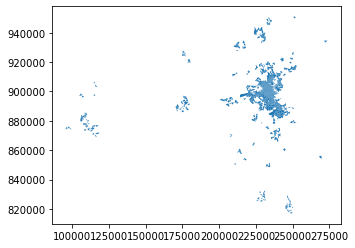

In [117]:
taz_fu.query('FU_Flag == 1').plot()

## Suburban

<AxesSubplot:>

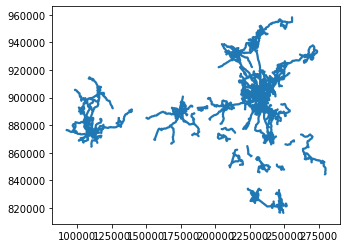

In [118]:
#do the buffers first
#convert miles to meters for CRS
buf5 = 0.5*1609.34
#make copy to copy buffer geo into
sub_buf = copy.deepcopy(sub_routes)
#do the buffers
sub_buf['geometry']= sub_buf.buffer(buf5)
#dissolve the buffers
sub_buf_dis = sub_buf.dissolve().reset_index()
sub_buf_dis.plot()

<AxesSubplot:>

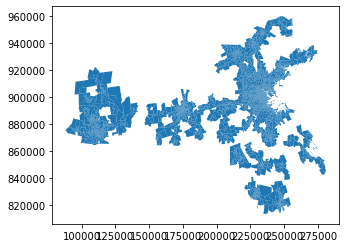

In [119]:
#calculate flag field
taz_su = copy.deepcopy(taz_fu)
#make list of all taz that intersect with sub_buf_dis
sub_list = []
for index, row in gpd.overlay(sub_buf_dis, taz_su, how = 'intersection').iterrows():
    sub_list.append(row['TAZ_ID'])
#flag where all previous flags are 0 and intersects with one of the buffers (included in list)
#taz_su['SUB_Flag'] = np.where(((taz_su['CBD_Flag'] != 1) & (taz_su['DU_Flag'] != 1) & (taz_su['FU_Flag'] != 1) & (taz_su['TAZ_ID'].isin(sub_list))), 1, 0)
#flag everything that intersects with one of the buffers (included in list)
taz_su['SUB_Flag'] = np.where(taz_su['TAZ_ID'].isin(sub_list), 1, 0)
taz_su.query("SUB_Flag == 1").plot()

## Rural

,TAZ_ID,TOT_EMP,TOT_POP,geometry,DensPy,Den_Flag,CBD_Flag,DU_Flag,FU_Flag,SUB_Flag,R_Flag
3819,60,2242.0,0.0,"POLYGON ((236565.617 900442.592, 236559.535 90...",566877.370417,1,1,1,1,1,0
3435,91,1014.0,406.0,"POLYGON ((235142.766 900260.496, 234965.958 90...",82438.316401,1,1,1,1,1,0
3411,79,986.0,237.0,"POLYGON ((235708.409 899897.901, 235710.048 89...",103503.723764,1,1,1,1,1,0
3424,19,3935.0,0.0,"POLYGON ((236620.143 899734.087, 236538.633 89...",87893.678803,1,1,1,1,1,0
2981,28,924.0,2417.0,"POLYGON ((235472.151 900720.237, 235470.732 90...",75751.048634,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1706,3114,1041.0,3137.0,"POLYGON ((177887.596 895680.042, 177952.258 89...",9739.109354,2,0,0,1,1,0
1705,3081,673.0,1063.0,"POLYGON ((185184.673 898004.477, 185194.131 89...",740.510714,3,0,0,0,0,1
1704,3254,474.0,1893.0,"POLYGON ((188567.377 896912.837, 188567.780 89...",3491.861175,3,0,0,0,0,1
1703,2261,959.0,382.0,"POLYGON ((191760.575 898608.945, 191776.726 89...",2695.011516,3,0,0,0,0,1


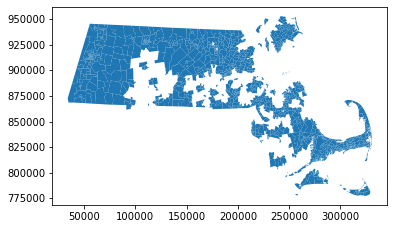

In [120]:
taz_ru = copy.deepcopy(taz_su)
taz_ru['R_Flag'] = np.where((taz_ru['CBD_Flag'] == 0) & (taz_ru['DU_Flag'] == 0) & (taz_ru['FU_Flag'] == 0) & (taz_ru['SUB_Flag'] == 0), 1, 0)
taz_ru.query('R_Flag == 1').plot()
taz_ru

## Make Land Use Type Column


In [109]:
taz_ru['LU_Type'] = np.where(taz_ru['CBD_Flag'] == 1, 1, 
                            np.where((taz_ru['CBD_Flag'] != 1) & (taz_ru['DU_Flag'] == 1), 2,
                            np.where((taz_ru['CBD_Flag'] != 1) & (taz_ru['DU_Flag'] != 1) & (taz_ru['FU_Flag'] == 1), 3,
                            np.where((taz_ru['CBD_Flag'] != 1) & (taz_ru['DU_Flag'] != 1) & (taz_ru['FU_Flag'] != 1) & (taz_ru['SUB_Flag'] == 1), 4, 5 
                            ))))
#CBD = 1, DU = 2, FU = 3, SUB = 4, Rural = 5
taz_ru

,TAZ_ID,TOT_EMP,TOT_POP,geometry,DensPy,Den_Flag,CBD_Flag,DU_Flag,FU_Flag,SUB_Flag,R_Flag,LU_Type
0,4398,1281.0,2489.0,"POLYGON ((246729.396 855385.947, 246722.786 85...",484.870934,3,0,0,0,1,0,4
1,2571,228.0,2060.0,"POLYGON ((247846.933 856739.946, 247846.686 85...",639.266855,3,0,0,0,0,1,5
2,2669,535.0,1523.0,"POLYGON ((249688.217 857104.522, 249688.216 85...",332.415073,3,0,0,0,0,1,5
3,4392,242.0,1441.0,"POLYGON ((251073.140 851003.532, 251079.000 85...",219.129925,3,0,0,0,0,1,5
4,2569,335.0,2075.0,"POLYGON ((248772.665 859041.357, 248774.263 85...",981.813634,3,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
5119,4791,64.0,507.0,"POLYGON ((308002.193 867516.135, 307995.932 86...",2309.375417,3,0,0,0,0,1,5
5120,4792,36.0,586.0,"POLYGON ((308368.955 866950.229, 308361.981 86...",4716.516148,3,0,0,0,0,1,5
5121,4793,126.0,760.0,"POLYGON ((316444.837 865421.734, 316453.462 86...",183.099881,3,0,0,0,0,1,5
5122,4795,276.0,610.0,"POLYGON ((318817.508 861617.237, 318782.352 86...",81.113893,3,0,0,0,0,1,5


## Exports for Testing

In [17]:
outfp = r"C:\Users\matkinson\Downloads\test_sep.shp"
taz_hr.to_file(outfp)

In [110]:
outfp = r"C:\Users\matkinson\Downloads\taz_ru_4allden.shp"
taz_ru.to_file(outfp)